# **Задание**

Учитывая все сложности, необходимо разработать модель машинного обучения, способную идентифицировать человека из заданной выборки по переданной в нее электрокардиограмме

Документация к бибилотеке wfdb по чтению ЭКГ https://wfdb.readthedocs.io/en/latest/index.html

# **0. Подготовка**

Устанавливаем зависимости. uninstall и install matplotlib лично мне помогло не напороться на ошибку выполнения

In [ ]:
pip install wfdb

In [ ]:
pip install BaselineRemoval

In [ ]:
pip uninstall matplotlib

In [ ]:
pip install -U matplotlib

Подключаем гугл-диск, на котором лежат ЭКГ

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Подключаем зависимости

In [ ]:
from IPython.display import display
import wfdb
from wfdb import processing
import pylab
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import cv2
import numpy as np
from scipy import sparse
from scipy.sparse import linalg
from scipy.signal import chirp, find_peaks, peak_widths
from numpy.linalg import norm
from scipy.interpolate import CubicSpline
from scipy.interpolate import splrep, splev

ModuleNotFoundError: ignored

Меняем директорию на ту, где лежат ЭКГ

In [ ]:
!pwd
import os
os.chdir('/content/drive/MyDrive/ECG/data/PATIENT_01')
!pwd

/content
/content/drive/MyDrive/ECG/data/PATIENT_01


# **1. Препроцессинг данных**

На графике присутствует 25 пиков. При нормальном ЧСС (60 уд/мин), получается, что время записи ЭКГ (ось х) - примерно 25 секунд.

In [ ]:
#Читаем файлы с ЭКГ
record = wfdb.rdsamp('rec_1')
display(record)
#Так как record - это tuple, где первый элемент - массив 10000*2, то вытаскиваем этот массив
#Он и является данными по оси y
#Этот массив содержит данные для фильтрованного и нефильтрованной ЭКГ
record_array=record[0]
#Создаем новый список, в который будем добавлять значения по оси y фильтрованной ЭКГ
filt_list=[]

#Наполняем список
for i in range(len(record_array)):
  filt_list.append(record_array[i][1])

#Создаем список, который содержит значения по оси x
x=list(range(0,10000))

#Отрисовка аналоговой ЭКГ
# an_record=wfdb.rdrecord('rec_1')
# wfdb.plot_wfdb(record=an_record, title='Patient_01, rec_1', figsize=(20,16))

(0.0, 1200.0)

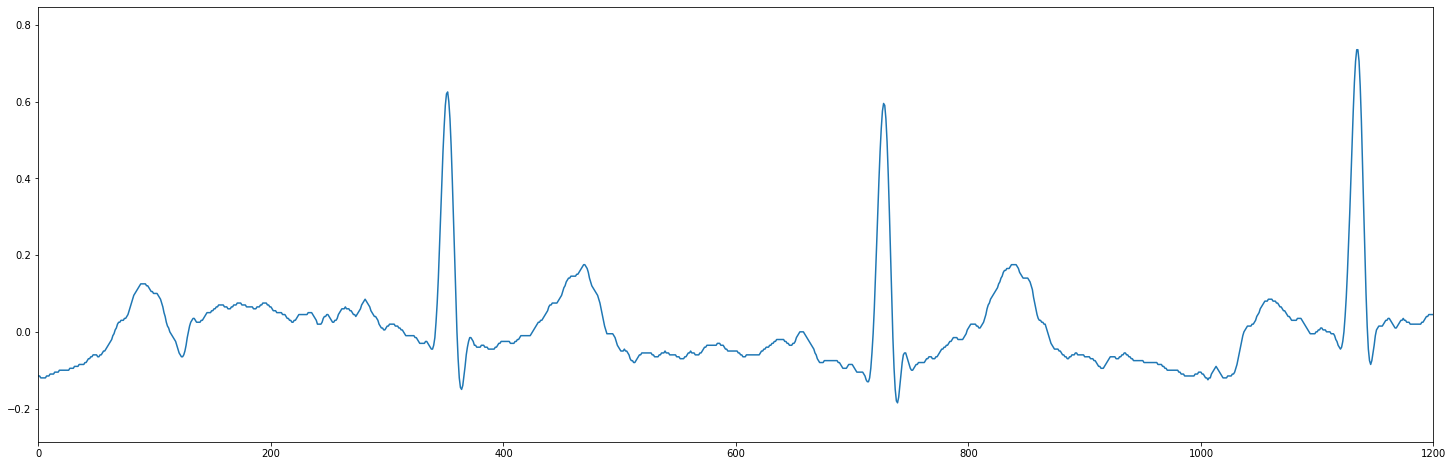

In [ ]:
#Отрисовка цифровой ЭКГ
figure(figsize=(25, 8))
plt.plot(x,filt_list)
plt.xlim([0, 1200])

Следующие 4 ячейки - выравнивание графика по 0. 
Код взят с https://stackoverflow.com/questions/29156532/python-baseline-correction-library

In [ ]:
def baseline_arPLS(y, ratio=1e-6, lam=100, niter=10, full_output=False):
    L = len(y)

    diag = np.ones(L - 2)
    D = sparse.spdiags([diag, -2*diag, diag], [0, -1, -2], L, L - 2)

    H = lam * D.dot(D.T) 

    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)

    crit = 1
    count = 0

    while crit > ratio:
        z = linalg.spsolve(W + H, W * y)
        d = y - z
        dn = d[d < 0]

        m = np.mean(dn)
        s = np.std(dn)

        w_new = 1 / (1 + np.exp(2 * (d - (2*s - m))/s))

        crit = norm(w_new - w) / norm(w)

        w = w_new
        W.setdiag(w)  

        count += 1

        if count > niter:
            print('Maximum number of iterations exceeded')
            break

    if full_output:
        info = {'num_iter': count, 'stop_criterion': crit}
        return z, d, info
    else:
        return z

In [ ]:
poly = CubicSpline(x, filt_list)
baseline = poly(x)

# noise = np.random.randn(len(x)) * 0.1
ano_filt_list = filt_list + baseline 
# + noise

In [ ]:
_, mod_filt_list, info = baseline_arPLS(ano_filt_list, lam=1e6, niter=100,
                                         full_output=True)

(0.0, 1200.0)

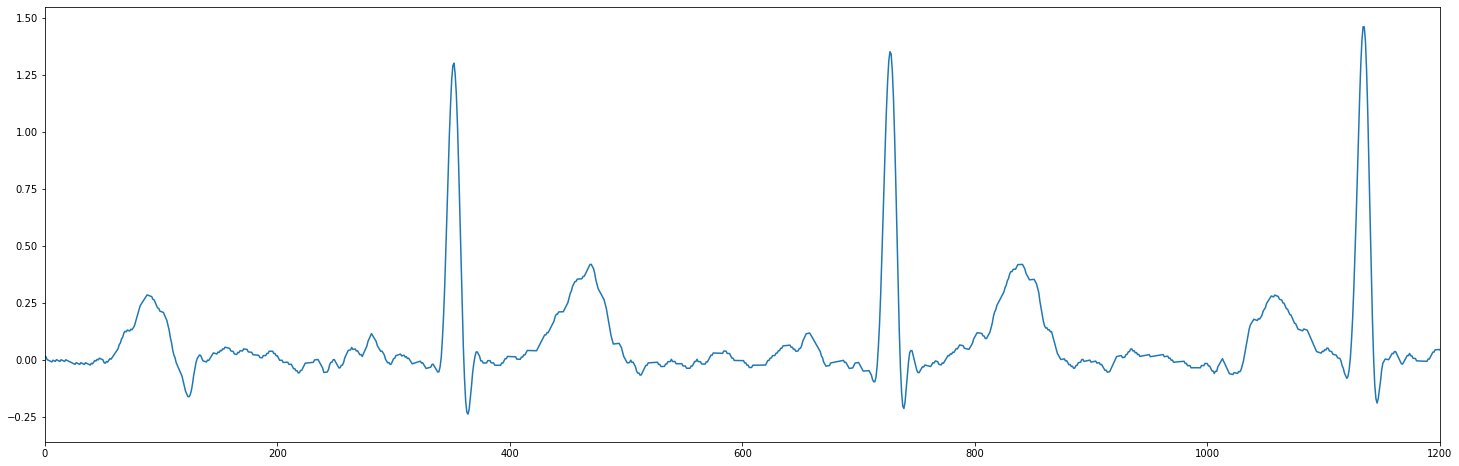

In [ ]:
figure(figsize=(25, 8))
plt.plot(x,mod_filt_list)
plt.xlim([0, 1200])

Сглаживаем график

In [ ]:
plt.figure()
bspl = splrep(x,mod_filt_list,s=5)
bspl_y = splev(x,bspl)
figure(figsize=(25, 8))
plt.plot(x,bspl_y)
plt.xticks(np.arange(0,10000,25))
plt.xlim([0, 1200])

print (bspl_y[0])

NameError: ignored

# **2. Извлечение фичей**

Код ниже позволяет найти и пики, и провалы

In [ ]:
all_peaks=processing.find_peaks(bspl_y)
hard_peaks=all_peaks[0]
hard_peaks

Код ниже позволяет найти только пики. Код взят с https://www.geeksforgeeks.org/find-a-peak-in-a-given-array/

In [ ]:
def find_feature(ecg, n):
 
  if (n == 1) :
    peaks_array.append(arr[0])
  if (arr[0] >= arr[1]) :
      peaks_array.append(arr[0])
  if (arr[n - 1] >= arr[n - 2]) :
      peaks_array.append(arr[n - 1])

  for i in range(1, n - 1) :
      if (arr[i] >= arr[i - 1] and arr[i] >= arr[i + 1]) :
          peaks_array.append(i)
             
arr = bspl_y
n = len(arr)
peaks_array=[]
find_feature(bspl_y, n)
peaks_array

Блок ниже рассчитывает ширину всех пиков

In [ ]:
results_full = peak_widths(bspl_y, peaks_array, rel_height=0.6)
np.set_printoptions(precision=3, suppress=True)
results_full[0]

Создаем словарь, где ключ - точки по оси х, значение - по оси у

In [ ]:
peaks_dict=dict(zip(x, bspl_y))
peaks_dict

Создаем список, который содержит все точки по оси х, которые имеют значение больше 1 (так как именно эти значения соответсвуют максимальному пику в сердцебиении - пику R)

In [ ]:
high_peaks=dict()
for key, value in peaks_dict.items():
    if value > 0.75:
        high_peaks[key] = value
    else:
        high_peaks[key] = 0
    
high_peaks

Но нам нужны не все точки по оси х, а только та, что имеет максимум по оси у

In [ ]:
max_peaks = []
for key, value in high_peaks.items():
    if key != 9999 and key != 0:
        if high_peaks[key] > high_peaks[key + 1] and high_peaks[key] > high_peaks[key - 1]:
            max_peaks.append(key)
max_peaks

# **3. Классификация**

# **4. Тестирование модели**